<a href="https://colab.research.google.com/github/DavideScassola/PML2024/blob/main/./Notebooks/06_bayesian_LR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 6: Bayesian Linear Regression & Classification

Probabilistic Machine Learning -- Spring 2024, UniTS


In this notebook, we explore linear regression and classification from a Bayesian point of view. In both cases, we start implementing the classical formulation and then we switch to the Bayesian version. We can then compare the methods on a simple example.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Linear Regression

The first model that we implement is the well known linear regression model and we use the "linear algebra view" that we studied during the lessons.

As a case study, we use the [Kaggle dataset](https://www.kaggle.com/datasets/budincsevity/szeged-weather/data) about Weather in Szeged (Hungary) between 2006 and 2016 and we try to predict the apparent temperature given some predictors.



In [ ]:
weatherHistory = pd.read_csv('https://raw.githubusercontent.com/DavideScassola/PML2024/main/Notebooks/data/weatherHistory.csv')
weatherHistory.head(5)

In [ ]:
weatherHistory.info()

In [ ]:
#Let's reduce the size of the dataset by considering one row for each day (corresponding to 16:00), only in 2015
#Training: April, Test: May
weatherHistory['Formatted Date'] = pd.to_datetime(weatherHistory['Formatted Date'], utc=True)
data = weatherHistory[((weatherHistory['Formatted Date'].dt.hour == 16) & (weatherHistory['Formatted Date'].dt.year == 2014) & (weatherHistory['Formatted Date'].dt.month == 4))].reset_index(drop=True)
data.info()
data_test = weatherHistory[((weatherHistory['Formatted Date'].dt.hour == 16) & (weatherHistory['Formatted Date'].dt.year == 2014) & (weatherHistory['Formatted Date'].dt.month == 5))].reset_index(drop=True)


In [ ]:
plt.scatter(data["Apparent Temperature (C)"], data["Humidity"], label = "train")
plt.scatter(data_test["Apparent Temperature (C)"], data_test["Humidity"], label = "test")

plt.xlabel("Humidity")
plt.ylabel("Apparent Temperature (C)")
plt.title("Apparent Temperature vs Humidity")

In order to perform the linear regression, we follow the maximum likelihood approach:
$$\theta_{ML} = \text{argmax } p(\underline{y} | \underline{x}, \theta)$$

and we define our parametric model as:
$$p(y|x, \theta) = \mathcal{N}(y|f(x,w), \beta^{-1})$$

where 

$$f(x,w) = w_0 \phi_0(x) + \ldots + w_{M-1}\phi_{M-1}(x)$$

with $\phi$ basis functions.

The weighs can be computed by:

$$w_M = \left( \Phi^T \Phi \right)^{-1} \Phi^T \underline{y}$$

where $\Phi$ is the design matrix.

In [ ]:
def linear_basis(x):
    return x

def linear_regression(x,y,basis_function):
    
    N = len(y)
    train_features = basis_function(x)
   
    X = np.hstack((np.ones((N,1)), train_features))
    print(f'matrice delle features: {X}')
   
    A = np.linalg.inv(X.T @ X)
    D = A @ X.T
    w = D @ y
   
    return np.dot(X, w), w

def predict_linear_regression(x,N,w,basis_function):
    
    train_features = basis_function(x)
    X = np.hstack((np.ones((N,1)), train_features))
    return np.dot(X, w)

We can perform the linear regression on the dataset and compute:

- Mean Squared Error (MSE): $$\text{MSE} = \frac{1}{N} \sum_{i=1}^N (y_i - \hat{y}_i)^2$$
- Log Likelihood: $$\sum_i -\frac{1}{2} \log(2\pi\sigma_i^2) - \frac{(y_i - \mu_i)^2}{2\sigma_i^2}$$


In [ ]:
#in this case x and y are row vectors, so we need to convert them to column vectors
x = data["Humidity"].to_numpy().reshape(-1,1)
y = data["Apparent Temperature (C)"].to_numpy().reshape(-1,1)

print("X (Humidity) vs Y (Apparent Temperature):")

beta = 0.01
print(np.sqrt(1/beta))

y_pred_linear, w = linear_regression(x,y,linear_basis)
print("X (Humidity) vs Y (Apparent Temperature) vs Y (prediction):")
print(np.hstack([x, y, y_pred_linear]))
print("w:")
print(w)

plt.scatter(data["Humidity"], data["Apparent Temperature (C)"], label = 'Data')
plt.scatter(data["Humidity"].to_numpy(), y_pred_linear, label = 'Predictions')
plt.xlabel("Humidity")
plt.ylabel("Apparent Temperature (C)")
plt.title("Linear Regression")
plt.legend()
plt.show()

print("MSE:")
print(np.mean((y_pred_linear.T-y)**2))
print("Log Likelihood:")
print(-len(y)/2*np.log(2*np.pi)-len(y)/2*np.log(1/beta) - 1/2*beta*np.sum((y_pred_linear.T-y)**2))

In [ ]:
#Let's see now on the test set

x_test = data_test["Humidity"].to_numpy().reshape(-1,1)
y_test = data_test["Apparent Temperature (C)"].to_numpy().reshape(-1,1)

y_test_pred= predict_linear_regression(x_test,len(x_test),w,linear_basis)

plt.scatter(data_test["Humidity"], data_test["Apparent Temperature (C)"], label = 'Data')
plt.scatter(data_test["Humidity"].to_numpy(), y_test_pred, label = 'Predictions')
plt.xlabel("Humidity")
plt.ylabel("Apparent Temperature (C)")
plt.title("Linear Regression (test data)")
plt.legend()
plt.show()

print("MSE:")
print(np.mean((y_test_pred.T-y_test)**2))
print("Log Likelihood:")
print(-len(y_test)/2*np.log(2*np.pi*1/beta) - 1/2*np.sum((y_test_pred.T-y_test)**2*beta))


In [ ]:
#Let's try to change the basis function

def square_basis(x):
    return  x**2   
def square_basis_5(x):
    return  x + x**2   
def square_basis_2(x):
    return np.hstack((x,x**2,x**3))
def square_basis_3(x):
    return np.hstack((x,x**2,x**3,x**4,x**5,x**6,x**7,x**8,x**9,x**10,x**11,x**12,x**13,x**14,x**15,x**16,x**17,x**18,x**19))

print(square_basis_2(2))

y_pred_1, w = linear_regression(x,y,linear_basis)
y_pred_2, w = linear_regression(x,y,square_basis)
y_pred_3, w = linear_regression(x,y,square_basis_5)
y_pred_4, w = linear_regression(x,y,square_basis_3)
# print('w:')
# print(w)

plt.scatter(data["Humidity"], data["Apparent Temperature (C)"], label = 'Data')
plt.scatter(data["Humidity"].to_numpy(), y_pred_1, label = 'Predictions linear')
plt.scatter(data["Humidity"].to_numpy(), y_pred_2, label = 'Predictions square')
plt.scatter(data["Humidity"].to_numpy(), y_pred_3, label = 'Predictions square_2')
# plt.scatter(data["Humidity"].to_numpy(), y_pred_4, label = 'Predictions square_3')
plt.xlabel("Humidity")
plt.ylabel("Apparent Temperature (C)")
plt.title("Linear Regression")
plt.legend()
plt.show()

# print("MSE:")
# print(np.mean((y_pred.T-y)**2))
# print("Log Likelihood:")
# print(-len(y)/2*np.log(2*np.pi)-len(y)/2*np.log(1/beta) - 1/2*beta*np.sum((y_pred.T-y)**2))

In [ ]:
#We can also consider more predictors

x = data[["Temperature (C)", "Humidity", "Wind Speed (km/h)"]].to_numpy()
y = data["Apparent Temperature (C)"].to_numpy().reshape(-1,1)

y_pred, w = linear_regression(x,y,linear_basis)

fig, ax = plt.subplots()
scatter = ax.scatter(data["Temperature (C)"], data["Humidity"], s = data["Wind Speed (km/h)"]*2, c = y_pred)
legend1 = ax.legend(*scatter.legend_elements(), loc = 'upper right', title="Predicted App. Temp.")
ax.add_artist(legend1)
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
legend2 = ax.legend(handles, labels, loc = 'lower left', title="Wind Speed")

plt.title("Linear Regression with more predictors")
plt.ylabel("Humidity")
plt.xlabel("Temperature (C)")
plt.show()

print("MSE:")
print(np.mean((y_pred.T-y)**2))
print("Log Likelihood:")
print(-len(y)/2*np.log(2*np.pi)-len(y)/2*np.log(1/beta) - 1/2*beta*np.sum((y_pred.T-y)**2))
print("Weights:")
print(w)

## Bayesian Linear Regression

We now consider a prior distribution on the weights, which in this case is:

$$p(w|\alpha) = \mathcal{N}(w| 0, \alpha^{-1} I)$$

So, we can use Bayes theorem to compute the posterior:

$$    p(w| \underline{x}, \underline{y}, \alpha, \beta) = \frac{p(\underline{y}| \underline{x}, w, \beta) p(w|\alpha)}{p(\underline{y}| \underline{x}, \alpha, \beta)}$$

and notice that it is a Gaussian distribution:

$$p(w|\underline{x}, \underline{y}, \alpha, \beta) = \mathcal{N} (w | m_N, S_N)$$

where 

$$m_N = \beta S_N \Phi^T \underline{y}$$
$$S_N^{-1} = \alpha I + \beta \Phi^T \Phi$$

Once we have the posterior distribution, we can calculate the predictive distribution as:

$$p(y|x, \underline{x} , \underline{y}, \alpha, \beta)  = \mathcal{N} \left(y| m_N^T \phi(x), \sigma_N^2(x) \right)$$

where 

$$\sigma_N^2(x) = \frac{1}{\beta} + \phi^T(x) S_N \phi(x)$$

For simplicity and for visualizing the result, we test on a single predictor.

In [ ]:
#Bayesian Regression with alpha and beta fixed and a gaussian prior

def bayesian_linear_regression(x,y,basis_function, alpha, beta):
    N = len(y)
    train_features = basis_function(x)
    
    X = np.hstack((np.ones((N,1)), train_features))
    # print(f'matrice delle features: {X.T}')
    
    SN_inv = alpha*np.eye(X.shape[1]) + beta*X.T @ X
    # print(f' alpha * I : {alpha*np.eye(X.shape[1])}')
    SN = np.linalg.inv(SN_inv)  # covariance posterior distribution
    mN = beta * SN @ X.T @ y    # mean posterior distribution
    
    return np.dot(mN.T, X.T), np.sqrt(1/beta + np.diag(X @ SN @ X.T)), mN, SN

def predict_bayesian_linear_regression(mN, SN, N, x, basis_function, beta):
    train_features = basis_function(x)
    X = np.hstack((np.ones((N,1)), train_features))
    mean = np.dot(mN.T, X.T)[0]                       # mean predictive distribution
    sigma = np.sqrt(1/beta + np.diag(X @ SN @ X.T))   # variance predictive distribution
    return mean, sigma

def plot_bayesian_LR(mN, SN, N, x, basis_function, beta):
    mean, sigma = predict_bayesian_linear_regression(mN, SN, N, x, basis_function, beta)
    plt.plot(x.T[0],mean)
    plt.fill_between(x.T[0], mean-sigma, mean+sigma, alpha=0.3)


In [ ]:
x = data["Humidity"].to_numpy().reshape(-1,1)
y = data["Apparent Temperature (C)"].to_numpy().reshape(-1,1)

x_test = data_test["Humidity"].to_numpy().reshape(-1,1)
y_test = data_test["Apparent Temperature (C)"].to_numpy().reshape(-1,1)

alpha = 0.002


y_pred_bayes, sigma_pred, mN, SN = bayesian_linear_regression(x,y,linear_basis, alpha, beta)
print("MSE (training set):")
print(np.mean((y_pred_bayes-y)**2))
print("Log Likelihood (training set):")
print(-1/2*np.sum(np.log(2*np.pi*sigma_pred**2)) - 1/2*np.sum(((y_pred_bayes-y)**2)/(sigma_pred**2)))

mean, sigma = predict_bayesian_linear_regression(mN, SN, len(x_test), x_test, linear_basis, beta)
# print(f' mN: {mN}')
# print(f' SN: {SN}')
# print(f' X_test.T: {x_test.T}')
# print(np.hstack([x_test, mean.reshape(-1,1), sigma.reshape(-1,1)]))
print("MSE (test set):")
print(np.mean((mean-y_test)**2))
print("Log Likelihood (test set):")
print(-1/2*np.sum(np.log(2*np.pi*sigma**2)) - 1/2*np.sum(((mean-y_test)**2)/(sigma**2)))



#FOR 1D features, we can plot the regression
xrange=np.linspace(0, 1, 100).reshape(-1,1)
plot_bayesian_LR(mN, SN, len(xrange), xrange, linear_basis, beta)

plt.scatter(data["Humidity"], data["Apparent Temperature (C)"], label='Data training')
plt.scatter(data_test["Humidity"], data_test["Apparent Temperature (C)"], label='Data test')

plt.xlabel("Humidity")
plt.ylabel("Apparent Temperature (C)")
plt.title("Bayesian Linear Regression")
plt.legend()
plt.show()

## Logistic Regression

### The problem

Given observations $(\textbf{x}_i, y_i)$ with $x_i \in \mathbb{R}^d$ and $y_i \in \{0,1\}$ we want to model $p(y | \textbf{x})$.

**Notation**

$\textbf{X}$: the dataset of input features $\textbf{x}_i$

$\textbf{Y}$: the dataset of targets $y_i$

In [40]:
import numpy as np
import pandas as pd
import os
import requests


# URL of the file to download
url = 'https://raw.githubusercontent.com/DavideScassola/PML2024/main/Notebooks/data/logistic_regression_data.npz'

# Send a HTTP request to the URL of the file
response = requests.get(url)

# Ensure the 'data/' directory exists
os.makedirs('data', exist_ok=True)

# Write the file
with open('data/logistic_regression_data.npz', 'wb') as f:
    f.write(response.content)

# loading the dataset
X = np.load('data/logistic_regression_data.npz')['X']
y = np.load('data/logistic_regression_data.npz')['y']

# Crea un DataFrame
df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
df['target'] = y
print(f' total data\n {df}')


# let's split it into train and test set and normalize it
def split_and_standardize(*, X, y, ratio=0.8):
    
    # Splitting train and test sets
    cut = int(ratio * len(y))
    X_train = X[:cut]
    y_train = y[:cut]
    
    X_test = X[cut:]
    y_test = y[cut:]
    
    # Standardizing data
    x_mean = X_train.mean(axis=0)
    x_std = X_train.std(axis=0)
    
    X_train = (X_train - x_mean) / x_std
    X_test = (X_test - x_mean) / x_std
    
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = split_and_standardize(X=X, y=y, ratio=0.04)

df = pd.DataFrame(X_train, columns=[f'feature_{i}' for i in range(X_train.shape[1])])
df['target'] = y_train
print(f'train data\n {df}')

df = pd.DataFrame(X_test, columns=[f'feature_{i}' for i in range(X_test.shape[1])])
df['target'] = y_test
print(f'test data\n {df}')

 total data
     feature_0  feature_1  target
0    0.441227  -0.330870       0
1    2.430771  -0.252092       0
2    0.109610   1.582481       0
3   -0.909232  -0.591637       1
4    0.187603  -0.329870       0
..        ...        ...     ...
95   0.249817   1.147202       0
96   0.835944   0.287404       0
97  -0.995596   0.906889       1
98   0.024211  -0.239982       1
99   0.910111   0.617845       0

[100 rows x 3 columns]
train data
    feature_0  feature_1  target
0  -0.063461  -0.500996       0
1   1.579113  -0.409813       0
2  -0.337246   1.713631       0
3  -1.178406  -0.802822       1
test data
     feature_0  feature_1  target
0   -0.272854  -0.499838       0
1   -1.412491  -0.355163       1
2   -0.723991   0.580467       1
3   -1.802196  -0.928456       0
4    0.522852   2.031759       0
..        ...        ...     ...
91  -0.221490   1.209813       0
92   0.262418   0.214631       0
93  -1.249708   0.931661       1
94  -0.407752  -0.395796       1
95   0.323650   0.597

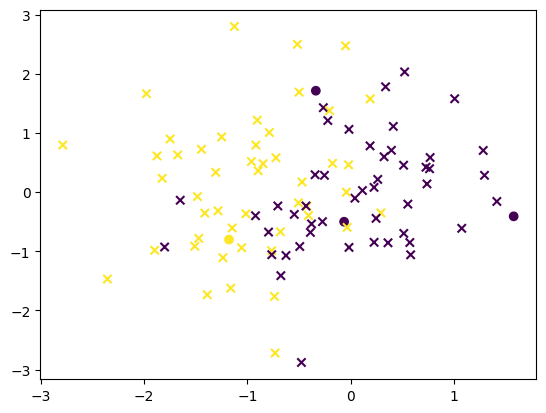

In [41]:
import matplotlib.pyplot as plt

_ = plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
_ = plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='x')

### The model

In logistic regression $p(y | \textbf{x})$ is modelled as:

$$p_{\textbf{w}}(y |  \textbf{x}) = Bernoulli(y; f(\textbf{w}^{T} \textbf{x})) $$

where $f : \mathbb{R} \rightarrow [0,1]$ is usually chosen to be the Logit $ \left( ({1 + e^{-k}})^{-1} \right)$ or the Probit.

Why $\textbf{w}^{T} \textbf{x}$ and not $\textbf{w}^{T} \textbf{x} + h$? For simplicity we prefer to avoid explicitly modelling the bias and we equivalently add a "1" as a feature to each data point. 

In [42]:
import numpy as np

# Add the "bias feature"
X_train = np.hstack([np.ones((X_train.shape[0], 1)), X_train])
X_test = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

print(f'X_train: {X_train}')
print(f'X_test: {X_test}')

def logit(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))


def likelihood(X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
    p = logit(X @ w)  # (n, d) @ (d, )
    return np.where(y == 1, p, 1 - p).prod()

X_train: [[ 1.         -0.06346129 -0.50099568]
 [ 1.          1.57911298 -0.40981329]
 [ 1.         -0.33724598  1.71363139]
 [ 1.         -1.17840571 -0.80282242]]
X_test: [[ 1.00000000e+00 -2.72854366e-01 -4.99837999e-01]
 [ 1.00000000e+00 -1.41249090e+00 -3.55163115e-01]
 [ 1.00000000e+00 -7.23990686e-01  5.80467288e-01]
 [ 1.00000000e+00 -1.80219550e+00 -9.28455853e-01]
 [ 1.00000000e+00  5.22852211e-01  2.03175908e+00]
 [ 1.00000000e+00 -1.67537539e+00  6.28358237e-01]
 [ 1.00000000e+00 -1.23733356e+00 -1.10979984e+00]
 [ 1.00000000e+00 -1.14756676e+00 -6.07062722e-01]
 [ 1.00000000e+00  3.94923971e-01  7.06572144e-01]
 [ 1.00000000e+00 -3.78910553e-01 -5.38544518e-01]
 [ 1.00000000e+00 -4.25024967e-01 -2.40637023e-01]
 [ 1.00000000e+00  2.27007356e-01 -8.49045540e-01]
 [ 1.00000000e+00 -4.32854786e-01 -2.35008493e-01]
 [ 1.00000000e+00 -4.70926041e-01  1.70432608e-01]
 [ 1.00000000e+00 -2.64551383e-01  1.42700669e+00]
 [ 1.00000000e+00 -4.99465053e-01  1.68938397e+00]
 [ 1.00000

### Maximum likelihood fitting (frequentist)

We fit our model $p_{\textbf{w}}(y |  \textbf{x})$ by finding parameters $w$ that maximize the likelihood according to our data. For numerical reasons we equivalently maximize the log-likelihood:

$$ \log{p_{\textbf{w}}(Y |  \textbf{X})} =  \log{ \prod_i {        p_{\textbf{w}}(y_i |  \textbf{x}_i)             }} = \sum_i \log{p_{\textbf{w}}(y_i |  \textbf{x}_i)} = \sum_i \log{Bernoulli(y_i; f(\textbf{w}^{T} \textbf{x}_i))}$$

We can find $w_{ML} = \argmax_{\textbf{w}}  \log{p_{\textbf{w}}(Y |  \textbf{X})}$ using numerical optimization, in particular we can use gradient descent:

$$ w_{n+1} = w_{n} + \eta \nabla_{\textbf{w}} \log{p_{\textbf{w}}(Y |  \textbf{X})} $$

where $\eta$ is the learning rate. How do we compute the gradient? We can compute it analyticallly, but we can also use automatic differentiation with `pytorch`.

In [46]:
import torch
from tqdm import tqdm

def log_likelihood(*, X: torch.Tensor, y: torch.Tensor, w: torch.Tensor) -> torch.Tensor:
    p = torch.sigmoid(X @ w)
    return torch.where(y == 1, torch.log(p + 1e-8), torch.log(1 - p + 1e-8)).sum()


def gradient_descent_optimization(*, loss_function, lr: float, n_iter: int, initial_guess: np.ndarray) -> np.ndarray:
    w = torch.tensor(initial_guess, dtype=torch.float32, requires_grad=True)
    for _ in tqdm(range(n_iter)):
        loss = loss_function(w)
        loss.backward()
        with torch.no_grad():
            w -= lr * w.grad
        w.grad = None
    print(f"loss={ loss.item():.4g}")
    return w.cpu().detach().numpy()

X_tensor = torch.tensor(X_train, dtype=torch.float32)
y_tensor = torch.tensor(y_train, dtype=torch.float32)
loss_function = lambda w: -log_likelihood(X=X_tensor,
                                          y=y_tensor,
                                          w=w)

w_mle = gradient_descent_optimization(loss_function=loss_function,
                                      initial_guess=np.zeros(X_train.shape[1]),
                                      lr=1e-2,
                                      n_iter=5000)













100%|██████████| 5000/5000 [00:01<00:00, 4144.80it/s]

loss=0.09124


In [47]:
# Veryfing the results

from sklearn.metrics import confusion_matrix

def predict(*, x: np.ndarray, w: np.ndarray) -> np.ndarray:
    return logit(x @ w)

def mean_cross_entropy(*, y: np.ndarray, pred: np.ndarray) -> float:
    return -np.where(y, np.log(pred + 1e-8), np.log(1 - pred + 1e-8)).mean()

frequentist_predictions = predict(x=X_train, w=w_mle)
print("confusion matrix: \n", confusion_matrix(y_train, frequentist_predictions > 0.5))
print(f"mean cross entropy: {mean_cross_entropy(y=y_train, pred=frequentist_predictions):.3g}")

Exception ignored in: <function tqdm.__del__ at 0x00000217853B6340>
Traceback (most recent call last):
  File "c:\Users\tomma\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\Users\tomma\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


confusion matrix: 
 [[3 0]
 [0 1]]
mean cross entropy: 0.0228


### Bayesian inference

In Bayesian Inference, we want to compute the **posterior distribution**:
$$p(\textbf{w} | \mathbf{X}, Y) \propto p(Y | \textbf{w}, \mathbf{X})p(\textbf{w})$$


where $p(\textbf{w})$ is the prior, and the **predictive distribution**:
$$p(y | \mathbf{x}, \mathbf{X}, Y) = \int p(y | \mathbf{x}, \textbf{w}) p(\textbf{w} | \mathbf{X}, Y) d\textbf{w}$$

notice that $\mathbf{X}$ is always in the conditioning, we are not interested in its distribution!

#### Posterior distribution

For the posterior $p(\textbf{w} | \mathbf{X}, Y) \propto p(Y | \textbf{w}, \mathbf{X})p(\textbf{w})$ we resort to the **Laplace Approximation**:

$$p(\textbf{w} | \mathbf{X}, Y) \approx \mathcal{N}(\textbf{w}; \mu_D, \Sigma_D)$$

where $\mu_D = \textbf{w}_{MAP}$ and $\Sigma_D =  \left( - \nabla_w \nabla_w \log{p(\textbf{w}_{MAP} | Y , \mathbf{X})} \right)^{-1}$

where $\textbf{w}_{MAP} = \argmax_{\textbf{w}} \left[ p(\textbf{w} | \mathbf{X}, Y) \right]$ is the **maximum a posteriori**, equivalently $\textbf{w}_{MAP} = \argmax_{\textbf{w}}  \left[ \log{p(Y | \textbf{w}, \mathbf{X})} + \log{p(\textbf{w})} \right]$


In [ ]:
# We can assume a Gaussian prior for the weights, with zero mean and a certain diagonal covariance matrix
from torch.distributions import Normal

PRIOR_STD = 100

def log_prior(w):
    return Normal(0, PRIOR_STD).log_prob(w).sum()

def log_unnormalized_posterior(*, X, y, w):
    return log_likelihood(X=X, y=y, w=w) + log_prior(w)

loss_function = lambda w: -(log_unnormalized_posterior(X=X_tensor, y=y_tensor, w=w))

w_map = gradient_descent_optimization(loss_function=loss_function,
                                      initial_guess=np.zeros(X_train.shape[1]),
                                      lr=1e-2,
                                      n_iter=5000)

In [ ]:
def compute_hessian(*, f, w):
    w.requires_grad = True
    grad = torch.autograd.grad(f(w), w, create_graph=True)[0]
    hessian = torch.zeros((w.numel(), w.numel()))
    for i in range(w.numel()):
        hessian[i] = torch.autograd.grad(grad[i], w, retain_graph=True)[0]
    w.requires_grad = False
    return hessian

hessian = compute_hessian(f=lambda w : log_unnormalized_posterior(X=X_tensor, y=y_tensor, w=w), w=torch.tensor(w_map, dtype=torch.float32))
posterior_cov = torch.inverse(-hessian).numpy()

In [ ]:
w_map

In [ ]:
posterior_cov

#### Predictive distribution

The approximation for the **predictive distribution** follows from the Laplace approximation of the posterior approximation (see lecture's notes for more details):
$$p(y | \mathbf{x}, \mathbf{X}, Y) \approx f\left(\kappa\left(\sigma_a^2\right) \mu_a\right)$$

where $\kappa\left(\sigma_a^2\right)=\left(1+\pi \frac{\sigma_a^2}{8}\right)^{-\frac{1}{2}}$ and $\mu_a$ and $\sigma_a^2$ are the mean and variance of the linear combination of the gaussian posterior with the observation $\mathbf{x}$.

So $\mu_a = \mathbf{\mu}_{D}^T \mathbf{x}$ and $\sigma_a^2 = \mathbf{x}^T \Sigma_{D} \mathbf{x}$

In [ ]:
def laplace_predictive_distribution(*, x, posterior_mean, posterior_cov):
    mu = x @ posterior_mean # (n, d) @ (d, )
    var = np.diag(x @ posterior_cov @ x.T)
    #var = np.array([X[i] @ posterior_cov @ X[i].T for i in range(len(X))])
    k = (1 + np.pi*var/8)**(-0.5)    
    return logit(mu * k)

bayesian_predictions = laplace_predictive_distribution(x=X_test, posterior_mean=w_map, posterior_cov=posterior_cov)

In [ ]:
X = {"train": X_train, "test": X_test}
y = {"train": y_train, "test": y_test}

freq_weights = w_map

predictor = {"frequentist": lambda x : predict(x=x, w=freq_weights),
             "bayesian": lambda x :  laplace_predictive_distribution(x=x, posterior_mean=w_map, posterior_cov=posterior_cov)}

for data in ('train', 'test'):
    for model in ('frequentist', 'bayesian'):
        pred = predictor[model](X[data])
        print(f"{model} {data} mean cross entropy: {mean_cross_entropy(y=y[data], pred=pred):.2f}")
        cm = confusion_matrix(y[data], pred > 0.5) / len(y[data])
        #print(f"{model} {data} confusion matrix: \n", np.round(cm,2))
        print(f"{model} {data} accuracy: {(cm[0,0] + cm[1,1]):.1%}")
        print()

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,4)
plt.rcParams["figure.dpi"] = 100

def plot_train_data(X, y):
    plt.scatter(X[y==1][:,1], X_train[y==1][:,2], c = 'red', marker='x', label='1')
    plt.scatter(X[y==0][:,1], X_train[y==0][:,2], c = 'red', marker='o', label='0')
    plt.legend()

def binary_crossentropy(*, true: np.ndarray, pred: np.ndarray):
    return -np.where(true, np.log(pred + 1e-8), np.log(1 - pred + 1e-8)).mean()

In [ ]:
plt.scatter(X_test[:,1], X_test[:,2], c = y_test, alpha = 0.8)
plot_train_data(X_train, y_train)
_ = plt.colorbar()

In [ ]:
pred = laplace_predictive_distribution(x=X_test, posterior_mean=w_map, posterior_cov=posterior_cov)
error = binary_crossentropy(true=y_test, pred=pred)
plt.scatter(X_test[:,1], X_test[:,2], c = pred, alpha = 0.8)
plot_train_data(X_train, y_train)
_ = plt.colorbar()

In [ ]:
pred = predict(x=X_test, w=freq_weights)
error = binary_crossentropy(true=y_test, pred=pred)
plt.scatter(X_test[:,1], X_test[:,2], c = pred, alpha = 0.8)
plot_train_data(X_train, y_train)
_ = plt.colorbar()

### Exercises

1. Try to repeat the analysis using more points

2. Try to repeat the analysis on the following dataset

In [ ]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = data.data
y = data.target 